In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
import seaborn as sns
from math import log2

In [2]:
# Load the Wine Quality dataset
data = pd.read_csv('winequality-red.csv')  
data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [3]:
# Display first few rows of the dataset
print(data.head())

   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5 

In [4]:
# Define ID3 Algorithm
class ID3DecisionTree:
    def _init_(self):
        self.tree = None
    
    def fit(self, X, y, feature_names):
        self.tree = self._id3(X, y, feature_names)
    
    def _entropy(self, y):
        total = len(y)
        counts = np.bincount(y)
        probabilities = counts / total
        return -np.sum(probabilities * np.log2(probabilities + np.finfo(float).eps))
    
    def _information_gain(self, X, y, feature):
        total_entropy = self._entropy(y)
        values, counts = np.unique(X[feature], return_counts=True)
        weighted_entropy = np.sum([
            (counts[i] / np.sum(counts)) * self._entropy(y[X[feature] == values[i]])
            for i in range(len(values))
        ])
        return total_entropy - weighted_entropy
    
    def _id3(self, X, y, feature_names):
        if len(np.unique(y)) == 1:
            return np.unique(y)[0]
        if len(feature_names) == 0:
            return np.bincount(y).argmax()
        
        best_feature = max(feature_names, key=lambda f: self._information_gain(X, y, f))
        tree = {best_feature: {}}
        remaining_features = [f for f in feature_names if f != best_feature]
        
        for value in np.unique(X[best_feature]):
            sub_X = X[X[best_feature] == value]
            sub_y = y[X[best_feature] == value]
            subtree = self._id3(sub_X, sub_y, remaining_features)
            tree[best_feature][value] = subtree
        
        return tree
    
    def _predict_one(self, tree, x):
        if not isinstance(tree, dict):
            return tree
        feature = list(tree.keys())[0]
        value = x[feature]
        subtree = tree[feature].get(value, np.bincount(y).argmax())
        return self._predict_one(subtree, x)
    
    def predict(self, X):
        return np.array([self._predict_one(self.tree, row) for _, row in X.iterrows()])

In [5]:
# Prepare the data
feature_names = data.columns[:-1]  # All columns except the last one
X = data[feature_names]
y = data['quality']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and train the ID3 Decision Tree
id3_tree = ID3DecisionTree()
id3_tree.fit(X_train, y_train, feature_names=feature_names)

# Make predictions
y_pred = id3_tree.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.54


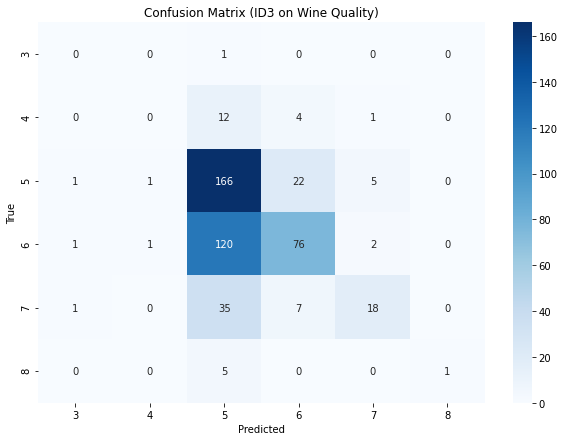

In [6]:
# Display confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (ID3 on Wine Quality)')
plt.show()

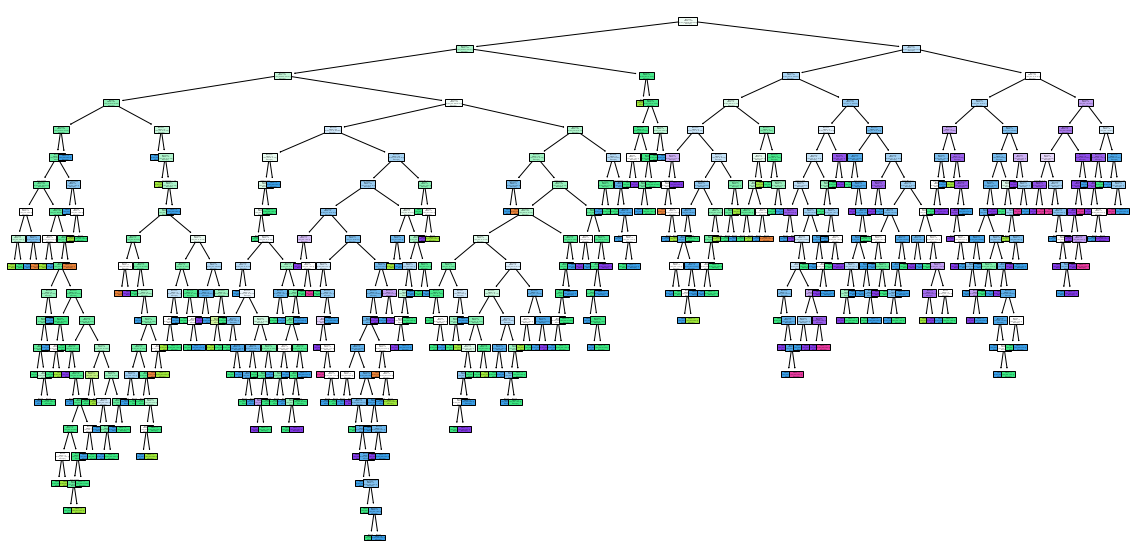

In [7]:
# Split features and labels
X = data.drop('quality', axis=1)  # Assuming 'quality' is the target
y = data['quality']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the Decision Tree model
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# Plot the Decision Tree
plt.figure(figsize=(20,10))
plot_tree(clf, filled=True, feature_names=X.columns, class_names=True)
plt.show()

In [8]:
# Display the tree (not a straightforward task without visualization libraries)
def print_tree(tree, indent=""):
    if not isinstance(tree, dict):
        print(indent + "Predict:", tree)
        return
    feature = list(tree.keys())[0]
    print(indent + feature + ":")
    for value, subtree in tree[feature].items():
        print(indent + "  " + str(value) + ":")
        print_tree(subtree, indent + "    ")

print("Decision Tree:")
print_tree(id3_tree.tree)

Decision Tree:
density:
  0.99007:
    Predict: 6
  0.9902:
    Predict: 6
  0.99064:
    Predict: 7
  0.9915:
    Predict: 6
  0.99154:
    Predict: 7
  0.99157:
    Predict: 7
  0.9916:
    Predict: 6
  0.99182:
    Predict: 7
  0.9921:
    Predict: 6
  0.9922:
    Predict: 6
  0.99236:
    Predict: 6
  0.9924:
    fixed acidity:
      5.1:
        Predict: 7
      5.6:
        Predict: 8
  0.99242:
    Predict: 6
  0.99256:
    Predict: 5
  0.99258:
    fixed acidity:
      5.0:
        Predict: 6
      5.6:
        Predict: 5
  0.9927:
    Predict: 7
  0.9928:
    Predict: 7
  0.99292:
    Predict: 6
  0.99294:
    Predict: 6
  0.99316:
    Predict: 7
  0.99318:
    Predict: 7
  0.9932:
    Predict: 6
  0.99322:
    Predict: 5
  0.99323:
    Predict: 6
  0.9933:
    Predict: 7
  0.9934:
    fixed acidity:
      4.6:
        Predict: 4
      5.0:
        Predict: 5
      5.3:
        Predict: 7
      6.4:
        Predict: 6
  0.99341:
    Predict: 5
  0.99344:
    Predict: 6
  0.993

In [9]:
# Display Entropy and Information Gain for each split/node
def calculate_split_metrics(X, y, feature_names):
    metrics = []
    for feature in feature_names:
        info_gain = id3_tree._information_gain(X, y, feature)
        metrics.append({
            'Feature': feature,
            'Entropy': id3_tree._entropy(y),
            'Information Gain': info_gain
        })
    return pd.DataFrame(metrics)

metrics_df = calculate_split_metrics(X, y, feature_names)
print('Entropy and Information Gain for each split/node:')
print(metrics_df)

Entropy and Information Gain for each split/node:
                 Feature   Entropy  Information Gain
0          fixed acidity  1.709062          0.242950
1       volatile acidity  1.709062          0.391637
2            citric acid  1.709062          0.235664
3         residual sugar  1.709062          0.194586
4              chlorides  1.709062          0.294324
5    free sulfur dioxide  1.709062          0.138687
6   total sulfur dioxide  1.709062          0.326481
7                density  1.709062          0.754254
8                     pH  1.709062          0.201716
9              sulphates  1.709062          0.319856
10               alcohol  1.709062          0.362977
